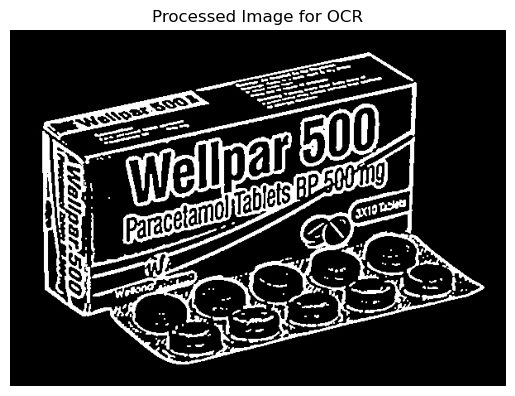

Detected Text:
 Wellpar500
Paracetamol Tablets

Tablet Name: Wellpar500 Paracetamol
Tablet Information:
Name: Wellpar500+Paracetamol
Description: DESCRIPTION: Pilocarpine hydrochloride tablets, USP contain pilocarpine hydrochloride, a cholinergic agonist for oral use. Pilocarpine hydrochloride, USP is a hygroscopic, odorless, bitter tasting white crystal or powder, which is soluble in water and alcohol and virtually insoluble in most non-polar solvents. Pilocarpine hydrochloride, USP with a chemical name of (3S- cis )-2(3 H )-Furanone, 3-ethyldihydro-4-[(1-methyl-1 H -imidazol-5-yl)methyl]monohydrochloride, has a molecular weight of 244.72. Each 5 mg Pilocarpine Hydrochloride Tablet, USP for oral administration contains 5 mg of pilocarpine hydrochloride. Inactive ingredients in the tablet are microcrystalline cellulose and stearic acid, the tablet's film coating is: polyvinyl alcohol, titanium dioxide, polyethylene glycol, and talc. Each 7.5 mg Pilocarpine Hydrochloride Tablet, USP for

In [1]:
import cv2
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk

def preprocess_image(image_path):
    #image reading with OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    #Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # GaussianBlur to reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    #adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    
    #Perform dilation and erosion to close gaps in between letter edges
    kernel = np.ones((2, 2), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    #Invert the image
    inverted = cv2.bitwise_not(closing)
    
    #Save the processed image
    processed_image_path = 'processed_image.jpg'
    cv2.imwrite(processed_image_path, inverted)
    
    return processed_image_path

def ocr_space_file(filename, api_key, overlay=False, language='eng'):
    payload = {
        'isOverlayRequired': overlay,
        'apikey': api_key,
        'language': language,
    }
    with open(filename, 'rb') as f:
        response = requests.post('https://api.ocr.space/parse/image',
                                 files={filename: f},
                                 data=payload,
                                 )
    return response.json()

def extract_tablet_name(text):
    #Split the text into lines
    lines = text.split('\n')
    
    #Search for the line with the tablet name, considering it might be in the same or adjacent lines
    potential_names = []
    for i in range(len(lines)):
        line = lines[i].strip()
        if 'Tablets' in line:
            #Check the previous line for the tablet name
            if i > 0:
                potential_names.append(lines[i-1].strip())
            #Also add the current line without 'Tablets'
            potential_name = line.replace('Tablets', '').strip()
            if potential_name:
                potential_names.append(potential_name)
    
    #Join the potential names to form the full name
    tablet_name = ' '.join(potential_names).strip()
    return tablet_name

def fetch_tablet_info(tablet_name):
    #Ensure the tablet name is correctly formatted for the API request
    tablet_name = tablet_name.strip().replace(' ', '+')
    
    #Base URL for OpenFDA drug label API
    openfda_base_url = f"https://api.fda.gov/drug/label.json?search=openfda.brand_name:{tablet_name}&limit=1"
    
    response = requests.get(openfda_base_url)
    
    if response.status_code == 200:
        results = response.json()
        if 'results' in results and len(results['results']) > 0:
            drug_info = results['results'][0]
            
            info = {
                'name': tablet_name,
                'description': drug_info.get('description', ['No description available'])[0],
                'usage': drug_info.get('indications_and_usage', ['No usage information available'])[0],
                'warnings': drug_info.get('warnings', ['No warnings available'])[0],
                'dosage': drug_info.get('dosage_and_administration', ['No dosage information available'])[0]
            }
            
            return info
        else:
            print(f"No results found for tablet name: {tablet_name}")
    elif response.status_code == 404:
        print(f"No results found for tablet name: {tablet_name} (status code: 404)")
    else:
        print(f"Failed to fetch drug information for tablet name: {tablet_name}, status code: {response.status_code}")
        
    return None

def display_tablet_info(info):
    # Create a new Tkinter window
    root = tk.Tk()
    root.title("Tablet Information")
    root.geometry("800x600")

    # Create a frame for the content
    frame = ttk.Frame(root, padding="10")
    frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

    # Add labels and text for each piece of information
    ttk.Label(frame, text="Tablet Information", font=("Helvetica", 16, "bold")).grid(row=0, column=0, columnspan=2, pady=(0, 10))

    row = 1
    for key, value in info.items():
        ttk.Label(frame, text=f"{key.capitalize()}:", font=("Helvetica", 12, "bold")).grid(row=row, column=0, sticky=tk.W)
        text_widget = tk.Text(frame, wrap="word", height=4, width=70, font=("Helvetica", 12))
        text_widget.insert(tk.END, value)
        text_widget.config(state=tk.DISABLED)
        text_widget.grid(row=row, column=1, sticky=tk.W, padx=(10, 0))
        row += 1

    # Run the Tkinter main loop
    root.mainloop()

# Your OCR.space API key
api_key = 'K87905376788957'

# Path to the uploaded image
image_path = 'paracetamol-tablets_1678696158.jpg'

# Preprocess the image
processed_image_path = preprocess_image(image_path)

# Display the processed image
img = cv2.imread(processed_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Processed Image for OCR')
plt.axis('off')
plt.show()

# Perform OCR on the processed image
result = ocr_space_file(filename=processed_image_path, api_key=api_key)

# Extract the recognized text
parsed_results = result.get('ParsedResults', [])
if parsed_results:
    for parsed_result in parsed_results:
        text_detected = parsed_result.get('ParsedText', '')
        print("Detected Text:\n", text_detected)
        
        # Extract tablet name
        tablet_name = extract_tablet_name(text_detected)
        if tablet_name:
            print("Tablet Name:", tablet_name)
            
            # Fetch tablet information
            tablet_info = fetch_tablet_info(tablet_name)
            if tablet_info:
                print("Tablet Information:")
                for key, value in tablet_info.items():
                    print(f"{key.capitalize()}: {value}")
                
                # Display tablet information in a new window
                display_tablet_info(tablet_info)
            else:
                print("No information found for the tablet.")
        else:
            print("Tablet name not found in the text.")
else:
    print("No text detected.")
